## Introduction

One way to analyze non-equilibrium force time traces from constraint pulling simulations is by calculating the work first and then estimating the free energy  $\Delta G$, via:

$$
\begin{align}
\Delta G(x) &=  \left< W(x) \right>_\text{N} -\frac{\beta}{2}\left<\delta W(x)^2\right>_\text{N} \\
			&=  \left<W(x)\right>_\text{N} - W_\text{diss}(x)
\end{align}
$$

with $\delta W(x) = W(x) -\left< W(x) \right>_\text{N}$. 
The expression is true if the work distribution is Gaussian. This allows to formulate the friction estimate: 

$$\Gamma(x) = \frac{1}{v_c}\frac{d~W_\text{diss}(x)}{dx}$$

This approach is implemented in the *WorkEstimator* class and computationally more efficient than calculating the force autocorrelation function (which is implemented in the ForceEstimator class), because the class works with the work data via the integration of the force time traces. This allows to reduce the resolution significantly while getting the same results.

Therefore, we recommend to use this approach for large datasets. 

## Workflow:

### 0. load packages and define variables

In [1]:
# load packages
import numpy as np
import dcTMD
from dcTMD.storing import WorkSet
from dcTMD.dcTMD import WorkEstimator

In [2]:
# define variables
velocity = 0.001
res = 1
verbose = True
temperature = 300


### I. create a work set

To calculate free energy and friction estimates a workset is needed. It contains the integrated force time traces. 

1. an array containing the filenames is generated. This can be done via the function dcTMD.io.load_pullf() which takes either a glob pattern or a file containing the pullf file names as argument.

In [3]:
pullf_files = '../../tests/testdata/pullf_filenames.dat'
pullf_files = '../../tests/testdata/*pullf.xvg'
filenames = dcTMD.io.load_pullf(pullf_files)

filenames


file ../../tests/testdata/*pullf.xvg not found. using glob.glob(../../tests/testdata/*pullf.xvg)


['../../tests/testdata/t_middle_32_pullf.xvg',
 '../../tests/testdata/t_middle_28_pullf.xvg',
 '../../tests/testdata/t_middle_09_pullf.xvg',
 '../../tests/testdata/t_middle_25_pullf.xvg',
 '../../tests/testdata/t_middle_03_pullf.xvg',
 '../../tests/testdata/t_middle_04_pullf.xvg',
 '../../tests/testdata/t_middle_17_pullf.xvg',
 '../../tests/testdata/t_middle_01_pullf.xvg',
 '../../tests/testdata/t_middle_30_pullf.xvg',
 '../../tests/testdata/t_middle_21_pullf.xvg',
 '../../tests/testdata/t_middle_05_pullf.xvg',
 '../../tests/testdata/t_middle_29_pullf.xvg',
 '../../tests/testdata/t_middle_31_pullf.xvg',
 '../../tests/testdata/t_middle_19_pullf.xvg',
 '../../tests/testdata/t_middle_16_pullf.xvg',
 '../../tests/testdata/t_middle_26_pullf.xvg',
 '../../tests/testdata/t_middle_24_pullf.xvg',
 '../../tests/testdata/t_middle_34_pullf.xvg']

2. the workset is created by creating a WorkSet instance which is fitted with the filenames. 

The resolution parameter controls the striding of the data set. The reduction is performed after integration the force time traces. For long trajectories e.g. 35,000,000 frames it is recommended to use a resolution > 1000 to not exceed common hardware limits.

In [4]:
# create WorkSet instance
workset = WorkSet(
    velocity=velocity,
    resolution=res,
    verbose=False,
)
workset


,velocity,0.001
,resolution,1
,verbose,False


In [5]:
# fit/fill workset
workset.fit(filenames)
# save workset
#dcTMD.storing.save('my_workset', workset)



Loading & integrating force files: 100%|██████████| 18/18 [00:00<00:00, 172.52it/s]


,velocity,0.001
,resolution,1
,verbose,False


In [6]:
print(vars(workset))

{'velocity': 0.001, 'resolution': 1, 'verbose': False, 'X': ['../../tests/testdata/t_middle_32_pullf.xvg', '../../tests/testdata/t_middle_28_pullf.xvg', '../../tests/testdata/t_middle_09_pullf.xvg', '../../tests/testdata/t_middle_25_pullf.xvg', '../../tests/testdata/t_middle_03_pullf.xvg', '../../tests/testdata/t_middle_04_pullf.xvg', '../../tests/testdata/t_middle_17_pullf.xvg', '../../tests/testdata/t_middle_01_pullf.xvg', '../../tests/testdata/t_middle_30_pullf.xvg', '../../tests/testdata/t_middle_21_pullf.xvg', '../../tests/testdata/t_middle_05_pullf.xvg', '../../tests/testdata/t_middle_29_pullf.xvg', '../../tests/testdata/t_middle_31_pullf.xvg', '../../tests/testdata/t_middle_19_pullf.xvg', '../../tests/testdata/t_middle_16_pullf.xvg', '../../tests/testdata/t_middle_26_pullf.xvg', '../../tests/testdata/t_middle_24_pullf.xvg', '../../tests/testdata/t_middle_34_pullf.xvg'], 'time_': array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 1.9998e+03, 1.9999e+03,
       2.0000e+03], shape=(20

### II. check normality of work distribution

One of the main conditions which need to be fulfilled for dcTMD is a normally distributed work.

This can be checked via different methods, e.g., plotting the work time traces, normality checks at different $x$, Kolmogorov-Smirnov test, Shapiro-Wilk test, Anderson-Darling test.

*Caution*: if the work distribution is not normal your results are compromised and a path separation is necessary.

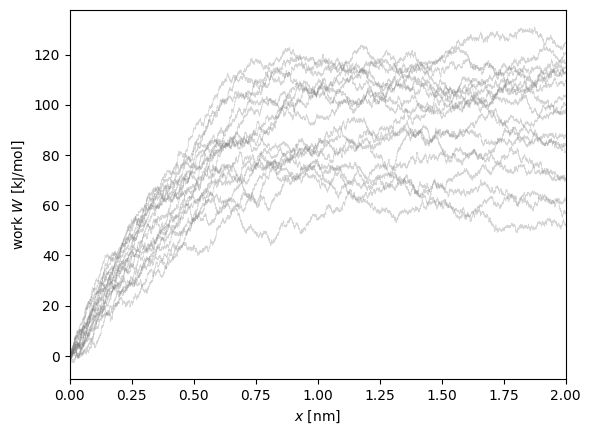

In [7]:
# plot workset
import matplotlib.pyplot as plt
from dcTMD.utils import plotting

fig, ax = plt.subplots()
plotting.plot_worklines(workset, ax)
plt.show()

In [8]:
from scipy.stats import probplot

def plot_worknormalitychecks(
    workset,
    index,
    x=None,
    worklinecolor='#777',
    colors=None,
    figsize=(6, 2),
    axs=None,
    res=10,
):
    """Plots the work values of trajectories individually.

    This function generates a plot with three subplots:
    1. Line plots of the work values for all trajectories.
    2. Work value histograms for the indices given `index`.
    3. As well as normality plot (Q-Q plot) for the work values the indices given `index`..

    Args:
        workset: workset object
        index (list of int): Indices of the positions. These indices
            are used to extract specific columns from `workset.work_` for
            histogram and normality plots.
        x (array-like, optional): The x-axis positions for the work values. If
            not provided, `workset.position_` is used.
        worklinecolor (str, optional): Color of the work line plot. Default is
            '#777'.
        colors (list of str, optional):
            Colors for the histogram and normality
            plots. If not provided, the `Dark2` colormap is used.
        figsize (tuple, optional):
            Size of the figure. Default is (6, 2).
        axs (list of matplotlib.axes.Axes, optional):
            Axes for the subplots. If
            not provided, new axes are created.
        res (int, optional): Resolution for the work line plot. Default is 10.

    Returns:
        list of matplotlib.axes.Axes: The axes containing the subplots.

    Example:
        >>> plot_worknormalitychecks(
        ...     workset=my_workset,
        ...     index=[0, 5, 10],
        ... )
        >>> plt.show()

    """
    if axs is None:
        print('No axs given. Create figure.')
        fig, axs = plt.subplots(
            ncols=3,
            nrows=1,
            figsize=figsize,
        )
    if x is None:
        x = workset.position_
    plotting.plot_worklines(workset, axs[0], x=x, res=res, color=worklinecolor)

    if not colors:
        cmap = plt.get_cmap('Dark2')
        colors = cmap.colors

    for j, idx in enumerate(index):
        work = workset.work_[:, idx].ravel()
        axs[1].set_title(r'Histogram at $x$')
        plotting.plot_histo_normaldist(work, axs[1], colors[j])
        axs[0].axvline(
            x[idx],
            color=colors[j],
            zorder=3,
            label=rf'$x={x[idx]:.2f}$',
        )

        probplot(work, plot=axs[2], fit=True)
        axs[2].get_lines()[j * 2].set_color(colors[j])  # noqa: WPS221
        axs[2].set_title('Normality plot')

    axs[0].legend()
    return axs

No axs given. Create figure.
shapiro wilkins results at x=0.5 is ShapiroResult(statistic=np.float64(0.9809889406089324), pvalue=np.float64(0.95963623434336))
anderson darling results at x=0.5 is AndersonResult(statistic=np.float64(0.1889729620402001), critical_values=array([0.503, 0.573, 0.687, 0.802, 0.954]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(67.28161594817962), scale=np.float64(12.135336573012399))
 success: True
 message: '`anderson` successfully fit the distribution to the data.').
Kolmogorov-Smirnov results at x=0.5 is KstestResult(statistic=np.float64(0.12229979875552988), pvalue=np.float64(0.9209557348362518), statistic_location=np.float64(-1.013218181258686), statistic_sign=np.int8(1))
shapiro wilkins results at x=1.5 is ShapiroResult(statistic=np.float64(0.9350144421408519), pvalue=np.float64(0.23768137296093406))
anderson darling results at x=1.5 is AndersonResult(statistic=np.float64(0.38109849215264546), 

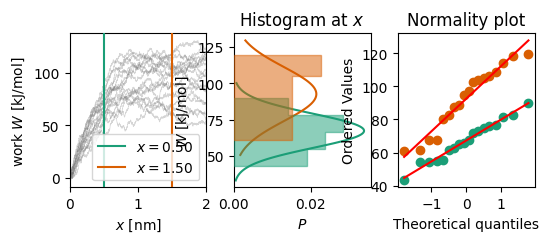

In [9]:
# check if work distribution follows a normal distribution
from scipy.stats import kstest, shapiro, anderson
from dcTMD.utils import plotting

index = [5000, 15000]
x = workset.position_

plot_worknormalitychecks(workset, index)

for i, p in enumerate(index):
    # Shapiro-Wilk Test
    shapiro_test = shapiro(workset.work_[:,p])
    print(f'shapiro wilkins results at x={x[p]} is {shapiro_test}')
    # Anderson-Darling Test
    # If the test statsitics is larger than the critical value of a given
    # significance_level in percent, the null hypothesis that the work
    # is normally distributed has to be rejected.
    anderson_test = anderson(workset.work_[:,p], 'norm')
    print(f'anderson darling results at x={x[p]} is {anderson_test}.')
    # Kolmogorov-Smirnov Test (requires centering and scaling of input data)
    kstest_test = kstest(
        (workset.work_[:,p]-np.mean(workset.work_[:,p]))/np.std(workset.work_[:,p]),
        'norm'
    )
    print(f'Kolmogorov-Smirnov results at x={x[p]} is {kstest_test}')

### III. derive estimates from workset

1. create WorkEstimator instance
2. fit WorkEstimator instance with previously created workset

In [10]:
# create WorkEstimator instance
workestimator = WorkEstimator(temperature)
# fit existing workset
# or load an existing workset
# workset = dcTMD.storing.load(my_workset)
workestimator.fit(workset)
vars(workestimator)

{'temperature': 300,
 'verbose': False,
 'work_set': WorkSet(velocity=0.001),
 'position_': array([0.0000e+00, 1.0000e-04, 2.0000e-04, ..., 1.9998e+00, 1.9999e+00,
        2.0000e+00], shape=(20001,)),
 'names_': array(['t_middle_32_pullf.xvg', 't_middle_28_pullf.xvg',
        't_middle_09_pullf.xvg', 't_middle_25_pullf.xvg',
        't_middle_03_pullf.xvg', 't_middle_04_pullf.xvg',
        't_middle_17_pullf.xvg', 't_middle_01_pullf.xvg',
        't_middle_30_pullf.xvg', 't_middle_21_pullf.xvg',
        't_middle_05_pullf.xvg', 't_middle_29_pullf.xvg',
        't_middle_31_pullf.xvg', 't_middle_19_pullf.xvg',
        't_middle_16_pullf.xvg', 't_middle_26_pullf.xvg',
        't_middle_24_pullf.xvg', 't_middle_34_pullf.xvg'], dtype='<U32'),
 'W_mean_': array([0.00000000e+00, 4.41837458e-02, 4.44572742e-02, ...,
        9.33136501e+01, 9.32887153e+01, 9.32516402e+01], shape=(20001,)),
 'W_diss_': array([0.00000000e+00, 1.16301148e-03, 5.56596643e-03, ...,
        1.03329006e+02, 1.032203

#### Visualize results
A couple of simple plot functions to get an overview of the results are implemented.

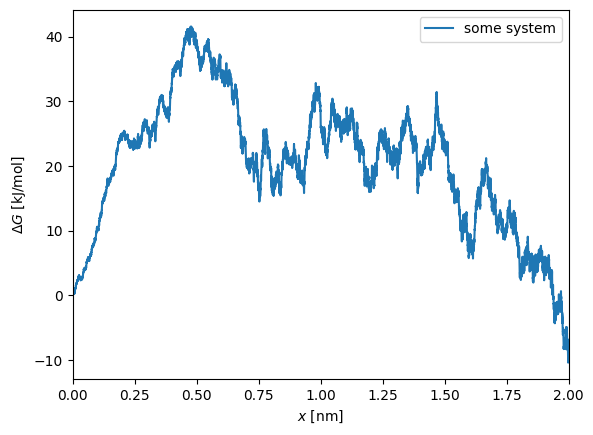

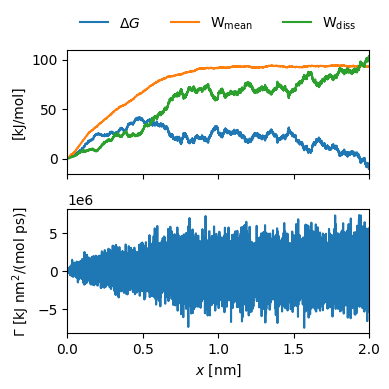

In [11]:
# plot dcTMD results
from dcTMD.utils import plotting

# plot free energy estimate
fig, ax = plt.subplots()
plotting.plot_dG(x, workestimator.dG_, ax, label='some system')
plt.legend()
plt.show()

# plot dcTMD results
fig, axs = plotting.plot_dcTMD_results(workestimator)
plt.show()

#### Smooth friction estimate
Finally, the friction estimate needs to be smoothed.
This can be done via 
`dcTMD.utils.smoothing.gaussfilter_friction()` or 
`dcTMD.WorkEstimator.smooth_friction(sigma, mode)`.

`sigma` is the standard deviation of gaussian kernel in nm,
`mode` determines how the input array is extended input array is extended when the filter overlaps a border, as used by `scipy.ndimage.gaussian_filter()`.

*Caution:* this can lead to long computation times when using large datasets and/or big smoothing windows.

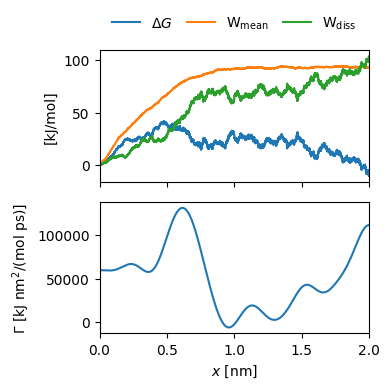

In [12]:
# smooth friction and plot results
workestimator.smooth_friction(sigma=0.1)

# if the friction is smoothed that value is automatically plotted
fig, axs = plotting.plot_dcTMD_results(workestimator)
plt.show()

# but one can also specify the friction
#fig, axs = plotting.plot_dcTMD_results(
#    workestimator,
#    friction=workestimator.friction_
#)

Using different smoothing windows and modes changes the results significantly. Because of the different boundary handling in the modes, `mode='nearest'` leads to an overestimation at the right hand border (end of the simulation), while `mode='reflect'` leads to a washing out of the boarder on the left hand side.

Here are some examples:

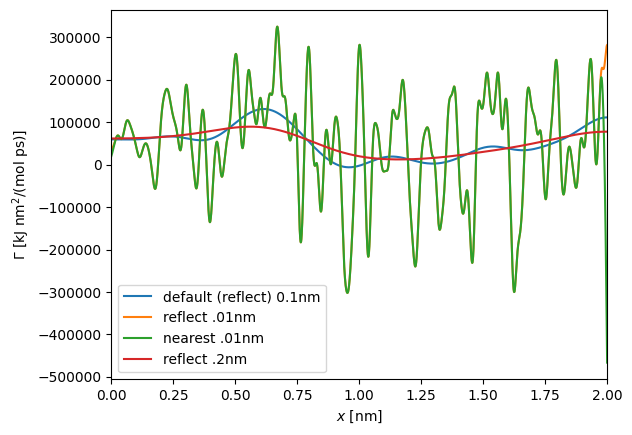

In [13]:
fig, axs = plt.subplots()

x = workestimator.position_
plotting.plot_Gamma(
    x,
    workestimator.friction_smooth_,
    axs,
    label='default (reflect) 0.1nm'
)

# using different smoothing windows and modes changes the results significantly
smooth_friction = dcTMD.utils.gaussfilter_friction(
    workestimator.friction_,
    x,
    sigma=.01,
    mode='reflect',
)
axs.plot(x, smooth_friction, label='reflect .01nm')
smooth_friction = dcTMD.utils.gaussfilter_friction(
    workestimator.friction_,
    x,
    sigma=.01, 
    mode='nearest',
)
axs.plot(x, smooth_friction, label='nearest .01nm')
smooth_friction = dcTMD.utils.gaussfilter_friction(
    workestimator.friction_,
    x,
    sigma=0.2,
    mode='reflect',
)
                                                   
axs.plot(x, smooth_friction, label='reflect .2nm')
axs.legend()

plt.show()

### IV. Error estimation

The error estimation of the results is implemented via bootstrapping:

Bootstrapping progress: 100%|██████████| 1000/1000 [00:01<00:00, 775.11it/s]


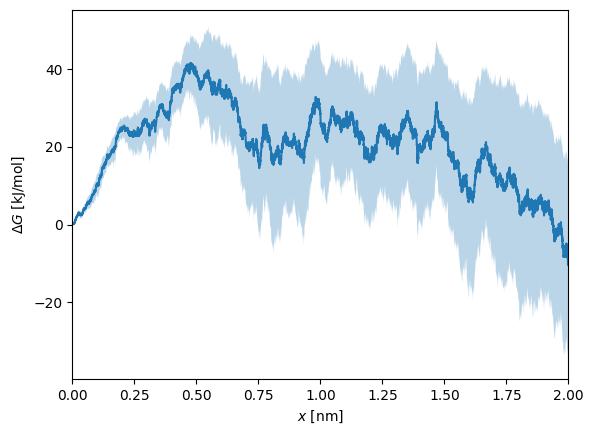

In [14]:

n_resamples = 1000

# bootstrapping error in mode std
mode = 'std'
workestimator.estimate_free_energy_errors(n_resamples, mode)

fig, ax = plt.subplots()
plotting.plot_dG_werrors(workestimator, ax)
plt.show()

Bootstrapping progress: 100%|██████████| 1000/1000 [00:01<00:00, 586.88it/s]


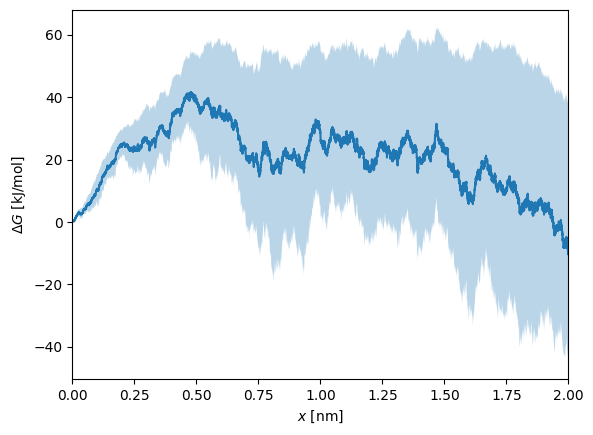

In [15]:
# bootstrapping error in with confidence interval 
# this gives a lower and upperbound estimate
confidence_interval = 0.9
mode = confidence_interval
workestimator.estimate_free_energy_errors(n_resamples, mode)

fig, ax = plt.subplots()
plotting.plot_dG_werrors(workestimator, ax)
plt.show()


### V. Save and load results

In [16]:
# save workestimator instance
dcTMD.storing.save('my_workestimator', workestimator)

# save data as .npz and .dat file
outname = 'my_workestimator_results'
dcTMD.io.write_output(outname, workestimator)

# if you want to save data as .dat file only:
dcTMD.io.write_output(outname, workestimator, filetype='.dat')

save file my_workestimator_results_N18.dat
save file my_workestimator_results_N18.npz
save file my_workestimator_results_N18.dat


In [17]:
# load results
results = dcTMD.io.load_output(f'{outname}_N{len(workestimator.names_)}.npz')
#results = dcTMD.io.load_output(f'{outname}_N{len(workestimator.names_)}.dat')

print(results.keys())

# results is a dictionary-like object
# access e.g. the free energy estimate

results['dG']

Loaded data from my_workestimator_results_N18.npz
dict_keys(['x', 'Wmean', 'Wdiss', 'dG', 'Gamma', 's_W_mean', 's_W_diss', 's_dG', 'Gamma_smooth'])


array([  0.        ,   0.04302073,   0.03889131, ..., -10.01535586,
        -9.93160192,  -9.84659417], shape=(20001,))